### Batch Feature selection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

import functools
import os
import sys
sys.path.append('../')
from vibrodiagnostics import (
    selection,
    models
)

#### Settings
Choose 0 for Fault, 1 for Anomaly

- 0, 0, 0 = Fault, az, Correlation
- 0, 0, 1 = Fault, az, F score
- 0, 0, 2 = Fault, az, MI

- 0, 2, 0 = Fault, bz, Correlation
- 0, 2, 1 = Fault, bz, F score
- 0, 2, 2 = Fault, bz, MI

- 0, 1, 0 = Fault, A, Correlation
- 0, 1, 1 = Fault, A, F score
- 0, 1, 2 = Fault, A, MI

- 0, 3, 0 = Fault, B, Correlation
- 0, 3, 1 = Fault, B, F score
- 0, 3, 2 = Fault, B, MI

In [4]:
OPTION = (0, 0, 1)

TARGETS = ['fault', 'anomaly']
AXIS_ALL = [['az'], ['ax', 'ay', 'az'], ['bz'], ['bx', 'by', 'bz']]
TITLES = ['Correlation', 'F score', 'Mutual information']
METRICS = [selection.corr_classif, f_classif, mutual_info_classif]

TARGET = TARGETS[OPTION[0]]
AXIS = AXIS_ALL[OPTION[1]]
TITLE = TITLES[OPTION[2]]
METRIC = METRICS[OPTION[2]]

In [5]:
PATH_PREFIX = '../../datasets/'
FEATURES_PATH =  os.path.join(PATH_PREFIX, 'features_data')

DATASET_PATH = os.path.join(PATH_PREFIX, 'MAFAULDA.zip')
MAFAULDA_METADATA = os.path.join(FEATURES_PATH, 'mafaulda_metadata.csv')

TD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_FEATURES_PATH)
FD_FEATURES = os.path.join(FEATURES_PATH, selection.FREQ_FEATURES_PATH)
TD_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_AND_FREQ_FEATURES_PATH)

TSFEL_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_FEATURES_PATH)
TSFEL_TD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_TIME_FEATURES_PATH)
TSFEL_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_FREQ_FEATURES_PATH)
TSFEL_SD_FEATURES = os.path.join(FEATURES_PATH, selection.TSFEL_STAT_FEATURES_PATH)

In [41]:
def scatter_3best_features(X, y, ranked_features, scaler_class=MinMaxScaler):
    columns = ranked_features.reset_index()['feature'].to_numpy()[:3]
    data = X[columns].copy()
    scaler = scaler_class()
    data[columns] = scaler.fit_transform(data)
    models.cross_cuts_3d(data, y)


def calculate_scores(x: pd.DataFrame, y: pd.DataFrame, metric) -> pd.DataFrame:
    scores = metric(x, y)
    if isinstance(scores, tuple):
        scores = scores[0]
    leaderboard = (
        pd.DataFrame(zip(x.columns, scores), columns=['feature', 'score'])
        .set_index('feature')
        .sort_values(by='score', ascending=False)
    )
    return leaderboard


def plot_best_features(X_train, y_train, X_test, y_test, title, metric, n=10):
    train_scores = calculate_scores(X_train, y_train, metric)
    test_scores = calculate_scores(X_test, y_test, metric)

    train_scores.rename(columns={'score': title}, inplace=True)
    test_scores.rename(columns={'score': title}, inplace=True)

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    train_scores.head(n).plot.bar(
        title='Training set', figsize=(8, 4), grid=True,
        xlabel='Feature', legend=False, ylabel=title, ax=ax[0]
    )
    test_scores.head(n).plot.bar(
        title='Testing set', figsize=(8, 4), grid=True,
        xlabel='Feature', legend=False, ylabel=title, ax=ax[1]
    )
    return {
        'train': train_scores, 
        'test': test_scores
    }


def pca_feature_importance(X, n=10):
    # Absolute values of the Eigenvectors' components corresponding to the k largest Eigenvalues.
    model = PCA(n_components=3).fit(X)
    X_pc = model.transform(X)

    columns = list(X.columns)
    percentages = [(100 * (np.flip(np.sort(np.abs(pc))) / np.sum(np.abs(pc))))[:n] for pc in model.components_]
    most_important = [np.flip(np.argsort(np.abs(pc)))[:n] for pc in model.components_]

    for i, pc in enumerate(most_important):
        print(f'PC{i+1} ({model.explained_variance_ratio_[i] * 100:.4f} %)')
        print([columns[x] for x in pc])
        print(percentages[i])

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TSFEL_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
scores = calculate_scores(X_train, y_train, METRIC)

features_normalized = selection.normalize_features(X_train, X_train.columns)
scores_norm = calculate_scores(features_normalized, y_train, METRIC)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
scores.head(15).plot.bar(figsize=(10, 4), grid=True, xlabel='Feature', ylabel=TITLE, legend=False, title='Unnormalized', ax=ax[0])
scores_norm.head(15).plot.bar(figsize=(10, 4), grid=True, xlabel='Feature', ylabel=TITLE, legend=False, title='Normalized', ax=ax[1])
plt.show()

#### TSFEL generated features in all domains

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TSFEL_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['test'], StandardScaler)
plt.show()

In [ ]:
pca_feature_importance(X_train)

#### TSFEL generated features in time domain

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TSFEL_TD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['test'], StandardScaler)
plt.show()

In [ ]:
pca_feature_importance(X_train)

TSFEL generated features in frequency (spectral) domain

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TSFEL_FD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], StandardScaler)
plt.show()

In [ ]:
pca_feature_importance(X_train)

#### TSFEL generated features in statistical domain

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TSFEL_SD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], StandardScaler)
plt.show()

In [ ]:
pca_feature_importance(X_train)

#### Custom features in all domains

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TD_FD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], StandardScaler)
plt.show()

#### Custom features in time domain

In [ ]:
X_train, X_test, y_train, y_test = models.features_subset_offline(TD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], StandardScaler)
plt.show()

In [ ]:
pca_feature_importance(X_train)

#### Custom features in frequency domain

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


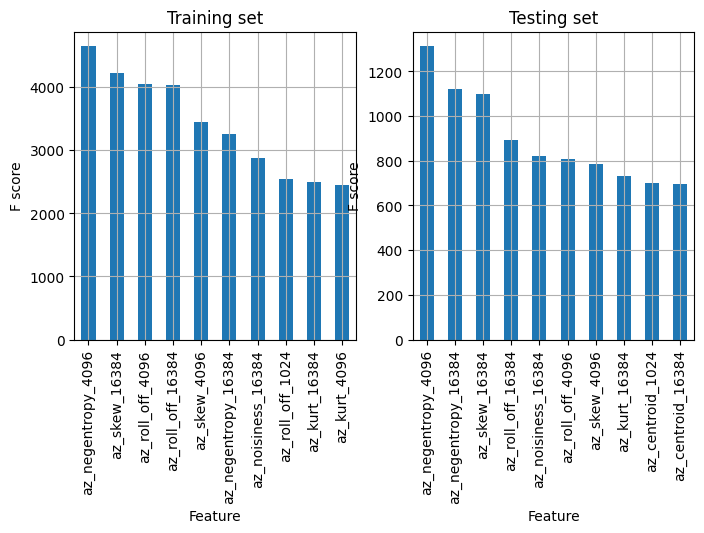

In [43]:
X_train, X_test, y_train, y_test = models.features_subset_offline(FD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
feature_set = plot_best_features(X_train, y_train, X_test, y_test, TITLE, METRIC)
plt.show()

/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/miroslav/.virtualenvs/dp/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


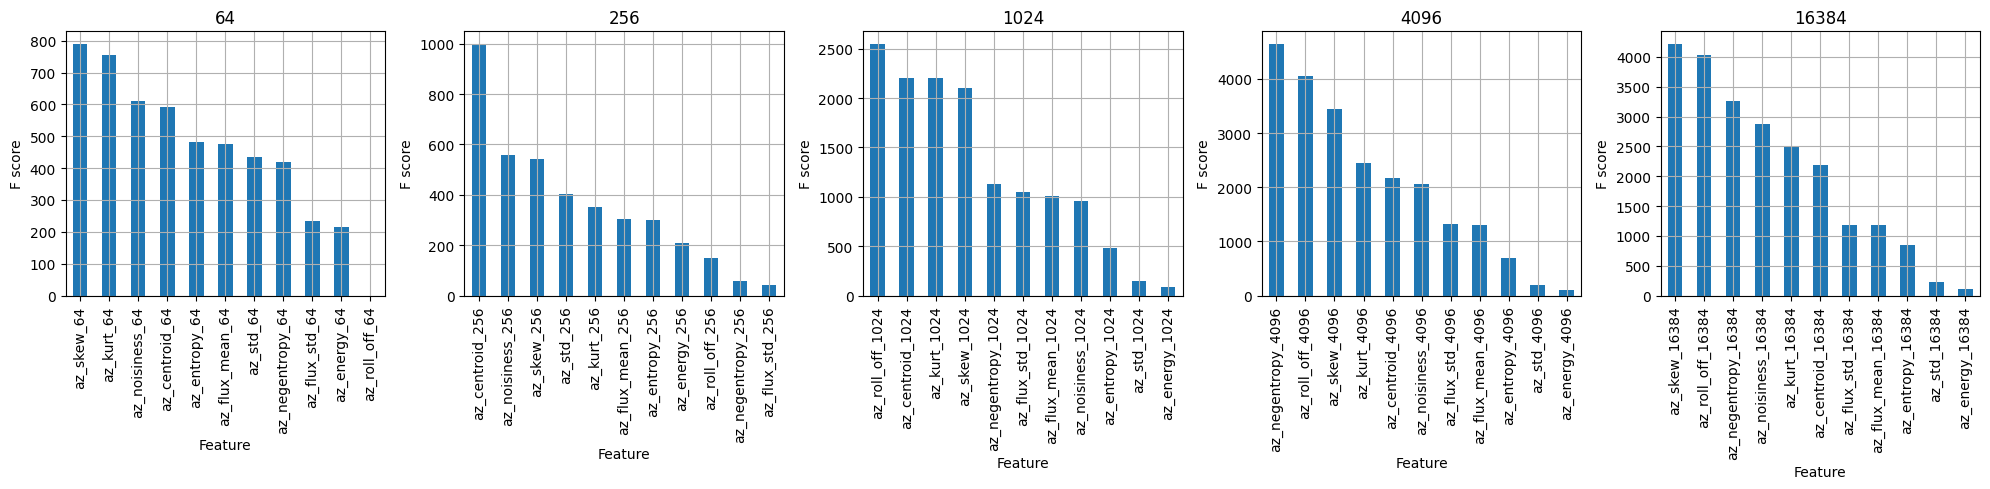

In [50]:
def plot_best_features_by_window_size(X, y, title, metric, n=10):
    window_sizes = (
        X.columns.str.extract(r'[\w\_]+_(\w+)$')[0]
         .dropna().unique().astype(int)
    )

    fig, ax = plt.subplots(1, len(window_sizes), figsize=(20, 5))

    for i, win_len in enumerate(window_sizes):
        columns = X.columns[X.columns.str.endswith(f'_{win_len}')]
        win_data = X.loc[:,X.columns.str.endswith(f'_{win_len}')]

        scores = calculate_scores(win_data, y, metric)
        scores.rename(columns={'score': title}, inplace=True)

        scores.plot.bar(
            title=f'{win_len}', grid=True,
            xlabel='Feature', legend=False, ylabel=title, ax=ax[i]
        )
    

X_train, X_test, y_train, y_test = models.features_subset_offline(FD_FEATURES, selection.FAULT_CLASSES, AXIS, TARGET)
plot_best_features_by_window_size(X_train, y_train, TITLE, METRIC)
plt.tight_layout()
plt.show()

In [ ]:
feature_set['train'].head(10)

In [ ]:
feature_set['test'].head(10)

In [ ]:
feature_set['train'].hist(bins=15, edgecolor='black', color='gray', figsize=(5, 3))
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], MinMaxScaler)
plt.show()

In [ ]:
scatter_3best_features(X_train, y_train, feature_set['train'], StandardScaler)
plt.show()

In [ ]:
pca_feature_importance(X_train)